Once you create a cool deep learning application, next step is to deploy it so that anyone all over the world can use your cool application. In this blog and 
[the next blog](https://fairyonice.github.io/Semantic-model-built-with-tensorflow-deployed-with-Flask-and-Heroku-Part-2.html), I will explore simple ways to deploy deep learning models into a public cloud platform. This blog will focus on the model development phase. 


Quick google search shows there are various public clouds that let us deploy our model: 

- [Amazon Web Service](https://aws.amazon.com/blogs/machine-learning/how-to-deploy-deep-learning-models-with-aws-lambda-and-tensorflow/)
- [Google Cloud](https://cloud.google.com/ml-engine/docs/deploying-models)
- [Heroku](https://www.heroku.com/)


The great advantages of AWS and Google cloud is that they offer GPU instances. However, it requires [DevOps work needed to set up a server](https://medium.com/@burgalon/deploying-your-keras-model-35648f9dc5fb) i.e., it takes longer for setting up the server. While Heroku does not offer GPU instance, it is VERY easy to set up and host at most 5 applications FOR FREE. It seems that Heroku is a good place to learn deployment in general for the first time. So this blog will use Heroku as a tool.


In the first blog post, I will create a simple deep learning model for sentiment analysis using tensor-flow. The model takes tweet or short text as a sentence and return the likelihood of happiness. 
Although it is relatively easy to deploy a prediction model to Heroku, this comes with some costs: for example, maximum slug size is [500 MB](https://devcenter.heroku.com/changelog-items/1145) or [ a request has not been processed by a worker within 30 secounds](https://devcenter.heroku.com/articles/error-codes#h13-connection-closed-without-response). Because of these restrictions, my focus in this blog was to simplify the model and to reduce the size of the model weights. 

[In the next blog](https://fairyonice.github.io/Semantic-model-built-with-tensorflow-deployed-with-Flask-and-Heroku-Part-2.html), I will discuss how to deploy this model in Heroku. If you are not interested in the model development, I recommend you to jump to the second phase.

## To motivate the readers, [click here to see my deployed web app](http://simple-text-prediction.herokuapp.com/) 

### Reference:
- [Deep learning semantic model built with tensorflow deployed using Flask and Heroku Part 1 (Model Development)](https://fairyonice.github.io/Semantic-model-built-with-tensorflow-deployed-with-Flask-and-Heroku-Part-1.html)
- [Deep learning semantic model built with tensorflow deployed using Flask and Heroku Part 2 (Deployment)](https://fairyonice.github.io/Semantic-model-built-with-tensorflow-deployed-with-Flask-and-Heroku-Part-2.html)

#  Sentiment analysis model development

Social media is a great place to share your thoughts about anything to anyone. 
Social media became a important place to learn public opinions.
Especially twitter is considered one of the most important place for this purpose because of its scale, diversity of topics and public access to the contents.

[SemEval](http://alt.qcri.org/semeval2017/task4/) offers public tweet dataset that researchers can share task on Sentiment Analysis on Twitter. The task ran in 2013, 2014, 2015 and 2016, attracting over 40+ participating teams in all four editions. I will use their public labeled data to develop a model that tells the happiness level.

I will first create a simgle layer LSTM model. Later, I will try transfer learning using GloVe weights.

To start, I import necessary modules.

In [1]:
import matplotlib.pyplot as plt
import sys, time, os, warnings 
import numpy as np
import pandas as pd 
from collections import Counter 

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" #"2,3" GPU 2 and 3 is only visible
import tensorflow as tf

warnings.filterwarnings("ignore")
print("python {}".format(sys.version))
print("tensorflow version {}".format(tf.__version__))


def set_seed(sd=123):
    from numpy.random import seed
    from tensorflow import set_random_seed
    import random as rn
    ## numpy random seed
    seed(sd)
    ## core python's random number 
    rn.seed(sd)
    ## tensor flow's random number
    set_random_seed(sd)

python 2.7.13 |Anaconda 4.3.1 (64-bit)| (default, Dec 20 2016, 23:09:15) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
tensorflow version 1.5.0


## Download data from SemEval website
The data is downloaded from [here](http://alt.qcri.org/semeval2017/task4/index.php?id=download-the-full-training-data-for-semeval-2017-task-4) and located at the following directory.

In [2]:
dir_data = "../Sentiment/2017_English_final/GOLD/Subtask_A/"

In [3]:
ls $dir_data

livejournal-2014test-A.tsv  twitter-2014test-A.txt
README.txt                  twitter-2015test-A.txt
sms-2013test-A.tsv          twitter-2015train-A.txt
twitter-2013dev-A.txt       twitter-2016dev-A.txt
twitter-2013test-A.txt      twitter-2016devtest-A.txt
twitter-2013train-A.txt     twitter-2016test-A.txt
twitter-2014sarcasm-A.txt   twitter-2016train-A.txt


## Load dataset
I will only use the training data because only training data contains labels.

In [4]:
def extractData(path_data):
    file = open(path_data,'r')
    text = file.read()
    file.close()

    texts = text.split("\n")
    data = []
    for line in texts:
        cols = line.split("\t")

        data.append(cols)

    data = pd.DataFrame(data)
    return(data)

d = {}
for i in [3,5,6]:
    path_data = dir_data + "twitter-201{}train-A.txt".format(i)
    d[path_data] = extractData(path_data)

print("combine the data")
data = pd.concat(d)    
data = data.reset_index()
data = data[[1,2]]
data.columns = ["class","text"]
## remove NaN
data = data.loc[~data["class"].isnull(),:]

combine the data


### Descriptive analysis
The distribution of the positive, neutral and negative tweets.
Roughly the same number of positive and negative tweets.


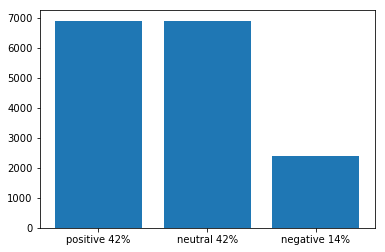

In [5]:
c = Counter(data["class"].values)
tot = np.sum(c.values())
labels = [str(k) + " "+ str(np.round(i*100/tot,3))+"%" for k,i in c.items()]

x = range(len(c))
plt.bar(x,c.values())
plt.xticks(x,labels)
plt.show()

## Example tweets
Let's take a look at 20 randomly selected raw tweets.

In [6]:
Ntweet = 20
index = np.random.choice(range(len(data)),Ntweet)
for i in index:
    row = data.iloc[i,:] 
    print("{:6}: {:}".format(row.iloc[0],row.iloc[1]))

positive: @owyposadas see you on Monday!!! SM Bacolod!!! woooohhhh
neutral: @KennethBartlet9 Rush said the other day that HRC was worst S.O.S. ever but Kerry is catching up..(may have been quoting someone)
positive: We are excited to announce our next Day on the Green on Sunday January 27th  - Australia Day Long Weekend! We are... http://t.co/P8BNE6NV
positive: Astrology may be a blasphemous concept to some\u002c but I am the absolute epitome of my sign. Every last detail.
positive: @USC_Zack @broncopeyton @gsf_23 lmfao when May comes around\u002c watch Zachary cheer for the Bulls or Celtics lololol
positive: @jurxssicpratt i just ordered one from Amazon it'll be here on Friday let's fucking rOLL
negative: "Ask for Lil Wayne, get Michael Jackson. Bug me about Wiz Khalifa, get Guns & Roses. The point of the night is to step outside the matrix.."
neutral: Chelsea need to beat Ajax to keep up there battle with Ajax for 2nd place #NextGenSeries
neutral: @Steilo_T2G lol yea I did nigga ! & 

## Give integer labels to indicate the negative, neutral and positive tweets
To simplify the problem and focus only on whether the tweet is happy, I will combine the negative and neutral tweets.
- Negative : 0
- Neutral : 0
- Positive : 1

This means that the 42% of tweets are 0 and 58% are 1. 

In [7]:
classes = []
for cl in data["class"]:
    if cl == "negative":
        classes.append(0)
    elif cl == "positive":
        classes.append(1)
    elif cl == "neutral":
        classes.append(0)
    else:
        print("SHOULD NOT BE HERE")
data["class"] = classes

## Text cleaning
I need to admit the this text cleaning section needs serious improvement... for example, I should remove URL or hash tags. 
We should also combine grammatically same words, e.g. "I've", "I have", "I hav" should be all treated the same. 
Serious text cleaning will improve the model performance substantially. I should also

For now, I just do:
 - get rid of quotes from the text 
 - assign a single space between word and !. So that ! is treated as a single word. Do the same for ?.


In [8]:
import re
from copy import copy
def clean_text(texts_original):
    texts = []
    
    for text in texts_original:
        otext = copy(text)
        text = otext.replace("!"," !").replace("?"," ?")
        text = text.replace('"',"")
        text = text.replace('“',"")
        text = text.replace('”',"")
        if text == "":
            print(otext)
        texts.append(text)
    return(texts)

data["text"] = clean_text(data["text"].values)

## Tokenizer 
Here I use Keras's preprocessing tokenizer to create a dictionary that maps word string to index ID.
I will only extract the 5000 most common words and everything else is ignored.

In [9]:
from tensorflow.contrib.keras import preprocessing
nb_words = 5000
tokenizer = preprocessing.text.Tokenizer(nb_words)
tokenizer.fit_on_texts(data["text"].values)
vocab_size = nb_words + 1

index_word = {v: k for k,v in tokenizer.word_index.items()}

print("The sentence has {} unique words".format(len(np.unique(tokenizer.word_index.keys()))))
print("> vocab_size={}".format(vocab_size ))

The sentence has 33795 unique words
> vocab_size=5001


### Record tokenizer
The tokenizer takes a string sentence, and create a list containing index IDs. 
This tokenizer also needs to be used during prediction to process the input sentence. 
So I need do save it. In general, tokenizer object can be saved and loaded using pickle as discussed in [stack overflow](https://stackoverflow.com/questions/45735070/keras-text-preprocessing-saving-tokenizer-object-to-file-for-scoring):


```
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
```

However, this create 1.5MB pickle object. This may or may not be too large for Heroku application, which only allows 500MB memory space and 30 seconds for every backend calculation.
In practice, this tokenizer function is quite simple: it just maps the word and the word index. 
So instead of saving the tokenizer object itself, I will just record the words in the order of ID and save it into a csv file. This file size is as small as 33KB.


In [10]:
mytokenizer = []
for i in range(1,nb_words+1):
    mytokenizer.append(index_word[i])
pd.DataFrame({"tokenizer":mytokenizer}).to_csv("tokenizer.csv",index=False)

The following code contains extract word_index dictionary and index_word dictionary from the csv.

In [11]:
def get_word_index_from_csv():
    tokenizer = pd.read_csv("tokenizer.csv")["tokenizer"].values
    word_index = {}
    index_word = {}
    for index,word in enumerate(tokenizer,1):
        word_index[word]=index
        index_word[index]=word
    return(word_index,index_word)

word_index, index_word = get_word_index_from_csv()


Now using word_index, encode each sentence.

In [12]:

def texts_to_sequences(line):
    out = []
    for l in line.split():
        llower = l.lower()
        if llower in word_index.keys():
            out.append(word_index[llower])
    return(out)


N = data.shape[0]
prop_train = 0.8
Ntrain = int(N*prop_train)
Ntest = N - Ntrain

sequences, index_train, index_test = [], [], [] 
count = 0
for irow,line in enumerate(data["text"]):
    encoded = texts_to_sequences(line)    
    sequences.append(encoded)
        
    if irow < Ntrain:
            index_train.append(count)
    else:
            index_test.append(count)
    count += 1
print('Total Sequences: %d' % (len(sequences)))

Total Sequences: 16173


Let's look at the example encoded tweets. 

In [13]:
def print_text(encoded):
    '''
    encoded : a list containing index e.g. [1, 300, 2]
    index_word : dictionary {0 : "am", 1 : "I", 2 : ".",..}
    '''
    for k in encoded:
        print("{}({})".format(index_word[k],k)),
    print("")
set_seed(1)        
random_index = np.random.choice(data.shape[0],20)
for irow,line in enumerate(data["text"].iloc[random_index]):
    encoded = texts_to_sequences(line)    
    print("irow={}".format(random_index[irow]))
    print_text(encoded)
    print("")

irow=13349
was(32) having(462) trouble(3840) yesterday(386) downloading(4818) edition(1409) using(1101) google(154) loads(3527) the(1) 1st(46) page(1020) then(100) 

irow=235
paid(1291) a(6) few(482) for(13) a(6) jim(924) white(392) record(612) if(42) i(3) recall(2421) but(30) not(43) in(5) the(1) so(37) i(3) may(21) well(157) be(20) missing(973) the(1) 

irow=12172
watching(142) tomorrow(18) just(28) because(186) conor(419) mcgregor(443) and(8) faber(4685) are(45) the(1) 

irow=5192
going(31) to(2) be(20) here(120) tomorrow(18) have(25) lots(959) to(2) swap(2022) london(450) book(388) swap(2022) via(261) 

irow=16127
anyone(244) want(85) to(2) come(90) to(2) kenny(2470) chesney(3899) and(8) jason(685) at(17) metlife(405) on(4) saturday(52) i(3) have(25) an(80) extra(1029) ticket(604) and(8) by(66) extra(1029) i(3) mean(603) a(6) plus(569) one(61) 

irow=905
safe(896) and(8) sound(729) at(17) airport(2197) feels(1512) good(69) to(2) be(20) back(94) at(17) the(1) land(2103) of(12) risin

Add zero padding to the sentence that is shorter than the maximum length.
This zero padding function will be also necessary in deployment. 


**X**

- X has a shape (N tweets, max length of tweet)
- X has zero padding when the original tweet length is less than max length of tweet.


In [14]:
def pad_pre_sequences(arr,maxlen):
    lines = []
    for iline in range(len(arr)):
        oline = arr[iline]
        lo = len(oline)
        if maxlen > lo:
            line = [0]*(maxlen - lo) + list(oline)
        else:
            
            line = oline[:maxlen]
        lines.append(line)
        if len(line) != maxlen:
            print(maxlen)
            print(line)
            
    lines = np.array(lines)
    return(lines)

max_length = max([len(seq) for seq in sequences])
X = pad_pre_sequences(sequences, maxlen=max_length)

print('Max Sequence Length: %d' % max_length)

Max Sequence Length: 33


One-hot encoding to create **y**

- y[i,0] == 1 if the i^th tweet is negative or neutral otherwise 0
- y[i,1] == 1 if the i^th tweet is positive otherwise 0

In [15]:
from keras.utils import to_categorical
y = to_categorical(data["class"].values, num_classes=2)

Using TensorFlow backend.


Split between training and testing data

In [16]:
X_train, y_train, X_test, y_test = X[index_train], y[index_train],X[index_test], y[index_test]

## Model definition
Here, I define a deep learning model with embedding layer + single layer LSTM followed by a single dense layer.
Notice that I am using tensorflow to extract Keras's models and layers.
I could have extracted these modules directly from Keras. However, somehow Heroku gave me warning when I try to import keras. Importing tensorflow did not yield the same error. This is the reason why I am using tensorflow in this blog post.  

In [17]:
from tensorflow.contrib.keras import models
from tensorflow.contrib.keras import layers

def define_model(input_length,Embedding,dim_out=2):
    
    hidden_unit_LSTM = 4
    main_input = layers.Input(shape=(input_length,),dtype='int32',name='main_input')
    embedding = Embedding(main_input)
    x = layers.LSTM(hidden_unit_LSTM)(embedding)
    main_output = layers.Dense(dim_out, activation='softmax')(x)
    model = models.Model(inputs=[main_input],
                  outputs=[main_output])
    
    # compile network
    model.compile(loss='categorical_crossentropy', 
              optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return(model)

dim_dense_embedding = 50
Embedding1 = layers.Embedding(vocab_size, 
                              dim_dense_embedding)
model1 = define_model(X.shape[1],Embedding1)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 33)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 33, 50)            250050    
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 880       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 10        
Total params: 250,940
Trainable params: 250,940
Non-trainable params: 0
_________________________________________________________________
None


## Training starts here:

In [18]:
import time 
start = time.time()
hist1 = model1.fit(X_train,y_train,
                   validation_data=(X_test,y_test),
                   epochs=10,batch_size=64,
                   verbose=2)
end = time.time()
print("Time took: {:3.2f}MIN".format((end - start)/60.0))

Train on 12938 samples, validate on 3235 samples
Epoch 1/10
 - 15s - loss: 0.6708 - acc: 0.5999 - val_loss: 0.7330 - val_acc: 0.4686
Epoch 2/10
 - 13s - loss: 0.6289 - acc: 0.6450 - val_loss: 0.7690 - val_acc: 0.5168
Epoch 3/10
 - 13s - loss: 0.5290 - acc: 0.7462 - val_loss: 0.7103 - val_acc: 0.5913
Epoch 4/10
 - 13s - loss: 0.4512 - acc: 0.8008 - val_loss: 0.7766 - val_acc: 0.5938
Epoch 5/10
 - 13s - loss: 0.4024 - acc: 0.8337 - val_loss: 0.8021 - val_acc: 0.5963
Epoch 6/10
 - 13s - loss: 0.3726 - acc: 0.8508 - val_loss: 0.8317 - val_acc: 0.6031
Epoch 7/10
 - 13s - loss: 0.3475 - acc: 0.8673 - val_loss: 0.8986 - val_acc: 0.5963
Epoch 8/10
 - 13s - loss: 0.3235 - acc: 0.8818 - val_loss: 1.0821 - val_acc: 0.5598
Epoch 9/10
 - 13s - loss: 0.3093 - acc: 0.8878 - val_loss: 0.9846 - val_acc: 0.5892
Epoch 10/10
 - 13s - loss: 0.2869 - acc: 0.8987 - val_loss: 0.9319 - val_acc: 0.6003
Time took: 2.17MIN


#### Validation loss and validation accuracies over epochs
The validation loss increases very quickly. Model is overfitting. 

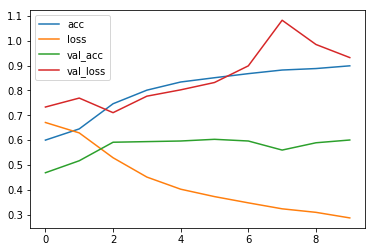

In [19]:
def plot_loss(hist1):
    for label in hist1.history.keys():
        plt.plot(hist1.history[label],label=label)
    plt.legend()
    plt.show()
plot_loss(hist1)

## Attempt 2: GloVe pre-trained weights
The model performance was not very good. 
Let's try to improve the model performance by transfer learning.

The researchers behind GloVe method provide a suite of pre-trained word embeddings on their website released under a public domain license. See:

- [GloVe: Global Vectors for Word Representation](https://nlp.stanford.edu/projects/glove/)

The smallest package of embeddings is called “glove.6B.zip“. 

Weights are trained with 6 billion tokens (words) with 400,000 vocabularies.
There are four dimensions of embedding vectors, i.e., 50d, 100d, 200d, and 300d.

```
wget 'nlp.stanford.edu/data/glove.6B.zip' 
```

unzipping gives four .txt files:

- 164M Aug  4  2014 glove.6B.50d.txt
- 332M Aug  4  2014 glove.6B.100d.txt
- 662M Aug  4  2014 glove.6B.200d.txt
- 990M Aug 27  2014 glove.6B.300d.txt



### Reference
- [nice example of how to use pre_trained word embedding with Keras](https://github.com/keras-team/keras/blob/master/examples/pretrained_word_embeddings.py)

In [20]:
dim_embedding = 50
path_GloVe = "../output/glove.6B.{}d.txt".format(dim_embedding)

def GloVe_embedding(path_GloVe):
    embeddings_index = {}
    with open(path_GloVe) as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print("{} vocabs ".format(len(embeddings_index)))
    return(embeddings_index)

GloVe_embedding = GloVe_embedding(path_GloVe)

400000 vocabs 


## Let's see 50 example tokens in GloVe
Some tokens contain digits, all the tokens are in lower case.

In [21]:
set_seed(10)
isamples = np.random.choice(len(GloVe_embedding),50)

def print_words(words):
    count = 1
    for word in words:
        print("{:20}".format(word)),
        if count % 5 == 0:
            print("")
        count += 1
    
print_words(np.array(GloVe_embedding.keys())[isamples])

ksl                  kruszwica            muzhakhoyeva         oberscharführer     toder                
bagbazar             frasca               disengaged           minicomputer         embraer              
palcy                jicheng              mym                  casariego            vestments            
lifejackets          amirian              markie               lemisch              cuisine              
rocked               flatterer            nilin                edmonson             safarova             
biking               unfavorable          tpn8                 cupa                 cobleskill           
laryngology          stadtmuseum          colleagues           hưng                countervailing       
drillers             prinn                jaywalker            castaños            384                  
wtvh                 first-rate           tennesse             alania-d             mazraeh-ye           
hentschel            pollsters            eluding

Now let's look at the vocabularies that do not appear in the GloVe but appear in the top 5000 most frequent words in my SemEval data.

In [22]:
word_not_in_GloVe= np.array(list(set(word_index.keys()) -  set(GloVe_embedding.keys())))
Nvoc = len(tokenizer.word_index.keys())
print("Out of {} vocabulary in original data, {} exists in the vocabulary of GloVe".format(
     Nvoc, Nvoc - len(word_not_in_GloVe)))
print("Following {} tokens ({:4.2f}%) do not exist in GloVe!!".format(
    len(word_not_in_GloVe),len(word_not_in_GloVe)*100/float(Nvoc)))
print("-"*100)
isamples = np.random.choice(len(word_not_in_GloVe),50)
print_words(word_not_in_GloVe[isamples])


Out of 33795 vocabulary in original data, 33613 exists in the vocabulary of GloVe
Following 182 tokens (0.54%) do not exist in GloVe!!
----------------------------------------------------------------------------------------------------
you're               madonna's            ibm's                we've                samsung's            
i've                 trndnl               i'm                  monday's             ticketek             
justinbieber         coleswindell         oneil                beiber               cobain's             
amandawanxo          hahaha               30pm                 trndnl               i'm                  
i'm                  federer's            hillary's            gears3               tomcc                
we've                i'm                  monthsary            sanders'             grimmie              
15pm                 pinkcity             bush's               tonight's            they'll              
xfactor              h

Not all the embedding vector is necessary for training. 
I will simply extract the embedding vectors that appear in our tweeter data.

In [23]:
# prepare embedding matrix
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, dim_embedding))
count = 0
for word, i in tokenizer.word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = GloVe_embedding.get(word)
    if embedding_vector is None:
        count+= 1
    else:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
print(" {} tokens did not exist".format(count))

 182 tokens did not exist


## Define the model
This time, I will provide embedding matrix from GloVe and freeze the parameters.
Notice that the model summary shows that there are only 890 trainable weights. These are the weights from LSTM and Dense layers.

In [24]:
dim_dense_embedding = embedding_matrix.shape[1]
Embedding2 = layers.Embedding(vocab_size, dim_dense_embedding,
                              weights=[embedding_matrix],
                              trainable=False)
model2 = define_model(X.shape[1],Embedding2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 33)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 33, 50)            250050    
_________________________________________________________________
lstm_2 (LSTM)                (None, 4)                 880       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 10        
Total params: 250,940
Trainable params: 890
Non-trainable params: 250,050
_________________________________________________________________
None


## Model training

In [25]:
start = time.time()
hist2 = model2.fit(X_train,y_train,
                 epochs=10,batch_size=64,
                 validation_data=(X_test,y_test),
                 verbose=2)
end = time.time()
print("Time took: {:3.1f}MIN".format((end - start)/60.0))

Train on 12938 samples, validate on 3235 samples
Epoch 1/10
 - 13s - loss: 0.6900 - acc: 0.5524 - val_loss: 0.7272 - val_acc: 0.4730
Epoch 2/10
 - 13s - loss: 0.6645 - acc: 0.6072 - val_loss: 0.7178 - val_acc: 0.4943
Epoch 3/10
 - 13s - loss: 0.6508 - acc: 0.6244 - val_loss: 0.6940 - val_acc: 0.5459
Epoch 4/10
 - 13s - loss: 0.6214 - acc: 0.6567 - val_loss: 0.6883 - val_acc: 0.5861
Epoch 5/10
 - 13s - loss: 0.5978 - acc: 0.6855 - val_loss: 0.6833 - val_acc: 0.5917
Epoch 6/10
 - 13s - loss: 0.5831 - acc: 0.6985 - val_loss: 0.6498 - val_acc: 0.6278
Epoch 7/10
 - 13s - loss: 0.5738 - acc: 0.7050 - val_loss: 0.6779 - val_acc: 0.6068
Epoch 8/10
 - 12s - loss: 0.5641 - acc: 0.7143 - val_loss: 0.6725 - val_acc: 0.6207
Epoch 9/10
 - 12s - loss: 0.5586 - acc: 0.7201 - val_loss: 0.6688 - val_acc: 0.6213
Epoch 10/10
 - 13s - loss: 0.5537 - acc: 0.7211 - val_loss: 0.6696 - val_acc: 0.6142
Time took: 2.1MIN


#### Validation loss and validation accuracies over epochs
The validation loss decreases more by using weights from GloVe. 

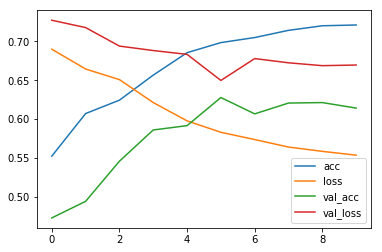

In [26]:
plot_loss(hist2)

## Save model 2
Save the model weights.
In the deployment, the model weights together with the tokenizer's word index are extracted during the prediction. 

In [27]:
model2.save_weights('sentiment_weights.h5')

## Model validation with example tweets
Hummm the happiness level makes some sense??!
In the next blog post, I will deploy this model to web app.

In [28]:

def predict(line,model):
    encoded = texts_to_sequences(line)
    sequences = pad_pre_sequences([encoded], maxlen=max_length)
    probs = model.predict(sequences)[0]
    ## The probability of positive tweet is recorded in the 1st position
    return(probs[1])



model = define_model(X.shape[1],Embedding1)
model.load_weights('sentiment_weights.h5')
word_index,_ = get_word_index_from_csv()


texts = ["I feel happy!",
         "What a great day!",
         "Going to work.",
         "I broke up with my boyfriend.",
         "happy happy",
         "happy happy happy happy so happy",
         "Life sucks",
         "I want to kill myself",
         "kill",
         "kill hate hate hate kill"]
for text in texts:
    print("Prob(Happy Tweet)={:5.3f}, {:20}".format(predict(text,model2),text))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 33)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 33, 50)            250050    
_________________________________________________________________
lstm_3 (LSTM)                (None, 4)                 880       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 10        
Total params: 250,940
Trainable params: 250,940
Non-trainable params: 0
_________________________________________________________________
None
Prob(Happy Tweet)=0.632, I feel happy!       
Prob(Happy Tweet)=0.665, What a great day!   
Prob(Happy Tweet)=0.350, Going to work.      
Prob(Happy Tweet)=0.343, I broke up with my boyfriend.
Prob(Happy Tweet)=0.914, happy happy         
Prob(Happy Tweet)=0.962,